In [1]:
import os
import scipy
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sbn

In [2]:
seed = 12
np.random.seed(seed)

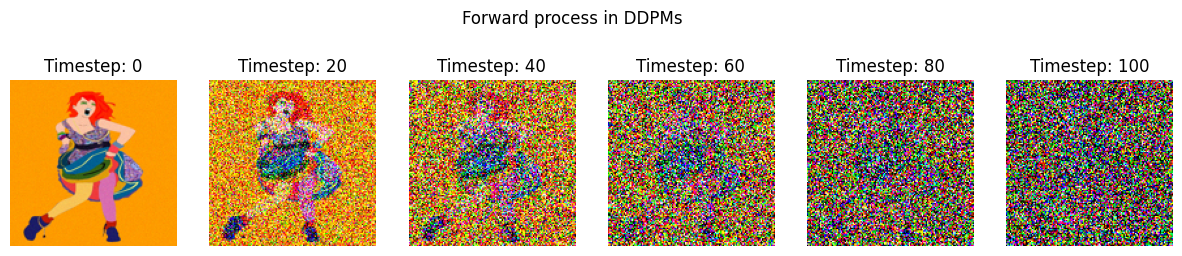

In [3]:
def forward_process_ddpms(img_t_minus_1, beta, t):
    """Implements the forward process of a DDPM model.
    
    Args:
        img_t_minus_1: Image at the previous timestep (t - 1)
        beta: Scheduled Variance
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    beta_t = beta[t].reshape(-1, 1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * img_t_minus_1
    sigma = np.sqrt(beta_t)
    
    # 3. Obtain image at timestep t using equation (15)
    img_t = mu + sigma * np.random.randn(*img_t_minus_1.shape)
    return img_t


# Let's check if ourforward process function is
# doing what it is supposed to do on a sample image
urllib.request.urlretrieve(
    "https://farm6.staticflickr.com/5012/5575143675_70933373dd_o.jpg",
    "5575143675_70933373dd_o.jpg"
)

# 1. Load image using PIL (or any other library that you prefer)
img = Image.open("5575143675_70933373dd_o.jpg")

# 2. Resize the image to desired dimensions
IMG_SIZE = (128, 128)
img = img.resize(size=IMG_SIZE)

# 3. Define number of timesteps
timesteps = 100

# 4. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


processed_images = []
img_t = np.asarray(img.copy(), dtype=np.float32) / 255.

# 5. Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    img_t = forward_process_ddpms(img_t_minus_1=img_t, beta=beta, t=t)
    if t%20==0 or t==timesteps - 1:
        sample = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
        processed_images.append(sample)

# 6. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.75)
plt.show()
plt.close()

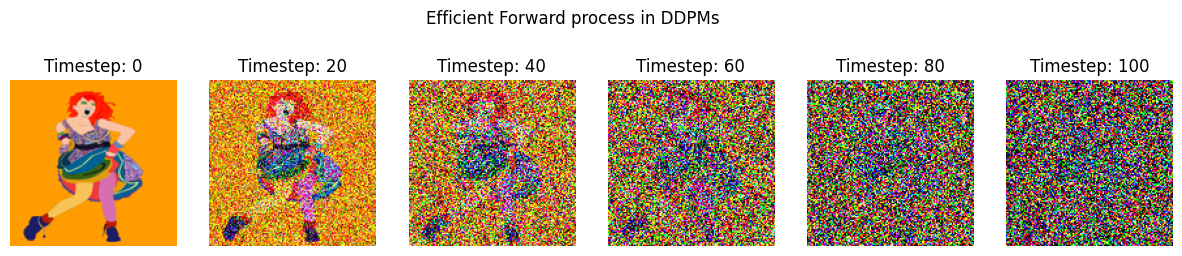

In [4]:
def forward_process_ddpms_v2(orig_img, alpha_bar, t):
    """Implements the efficient forward process of a DDPM model.
    
    Args:
        orig_img: Image at timestep t=0
        alpha_bar: The reparameterized version of beta
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt(alpha_bar_t) * orig_img
    sigma = np.sqrt(1.0 - alpha_bar_t)
    
    # 3. Obtain image at timestep t
    img_t = mu + sigma * np.random.randn(*orig_img.shape)
    return img_t



# 1. Define alpha and alpha_bar
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)


processed_images = [img] # Image at 0th step
orig_img = np.asarray(img.copy(), dtype=np.float32) / 255.


# 2. Run the forward pass for specific timesteps
# We will use the timesteps we used in previous visualizations
specific_timesteps = [19, 39, 59, 79, 99]
for step in specific_timesteps:
    img_t = forward_process_ddpms_v2(orig_img, alpha_bar, step)
    img_t = (img_t.clip(0, 1) * 255.0).astype(np.uint8)
    processed_images.append(img_t)

    
# 3. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

for i, sample in enumerate(processed_images):
    ax[i].imshow(sample)
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Efficient Forward process in DDPMs", y=0.75)
plt.show()
plt.close()

In [5]:
import torch
device = torch.device('mps')
x = torch.rand(10000,10000, dtype= torch.float32)
y = torch.rand(10000,10000, dtype= torch.float32)
x = x.to(device)
y = y.to(device)

In [6]:
%%timeit
x * y

7.45 ms ± 264 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
device = torch.device('cpu')
x = torch.rand(10000,10000, dtype= torch.float32)
y = torch.rand(10000,10000, dtype= torch.float32)
x = x.to(device)
y = y.to(device)

In [8]:
%%timeit
x * y

29.2 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
